In [1]:
from PIL import Image, ImageDraw
from io import BytesIO
import json
import joblib
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

random.seed(25)

SUP_DATA = './features_sup/clustering_outputs.torch'
OUTPUT_PATH = './imagenet_{}_intra_{}_inter_{}.json'
LT_DIST_PATH = './long-tail-distribution.pytorch' 

In [2]:
# change the label of clusters in a decreasing order
def cluster_ranking(cls_data):
    new_data = {}
    idx2label = {}
    label_num = []
    count_img = 0
    for key, val in cls_data.items():
        num_cat_img = sum([len(item) for item in val.values()])
        label_num.append((key, num_cat_img))
        count_img += num_cat_img
        cluster_paths = list(val.values())
        cluster_paths.sort(key=len, reverse=True)
        new_data[key] = {i : [] for i in range(3)}
        for i, paths in enumerate(cluster_paths):
            new_data[key][i//2] += paths
    # sort category by the number of images
    sorted_labels = sorted(label_num, reverse=True, key=lambda item: item[1])
    # sorted labels
    for i, item in enumerate(sorted_labels):
        idx2label[str(i)] = item[0]
        
    new_data = {str(i) : new_data[idx2label[str(i)]] for i in range(len(idx2label))}
    print('===== Total Number of Images is {} ====='.format(count_img))
    return new_data, idx2label

In [3]:
def generate_train_val_test(cls_data, VAL_SIZE=10, TEST_SIZE=20, NUM_CAT=1000, NUM_ATT=3, intra_type='lt', inter_type='bl'):
    trainset =         {'label':{}, 'frequency':{}, 'attribute':{}}
    valset =           {'label':{}, 'frequency':{}, 'attribute':{}}
    testset_lt =       {'label':{}, 'frequency':{}, 'attribute':{}}
    testset_bl =       {'label':{}, 'frequency':{}, 'attribute':{}}
    testset_bbl =      {'label':{}, 'frequency':{}, 'attribute':{}}
    
    # intra distribution
    intra_dist = [7,2,1]
    print('Intra-Distribution is ' + str(intra_dist))
    print_total_img(cls_data)
    
    #################################################
    # TEST BBL: generate test set that has the balanced
    # distribution for both category and attribute
    #################################################
    cls_data, testset_bbl =  generate_balanced_test(cls_data, testset_bbl, TEST_SIZE)
    print_total_img(cls_data)
    
    
    #################################################
    # TEST BL: generate test set that only has the balanced
    # class distribution
    #################################################
    if intra_type == 'lt' and inter_type == 'lt':
        cls_data, testset_bl = generate_intra_lt_test(cls_data, testset_bl, intra_dist, TEST_SIZE, NUM_ATT)
    elif intra_type == 'lt' and inter_type == 'bl':
        cls_data, testset_bl = generate_intra_lt_test(cls_data, testset_bl, intra_dist, TEST_SIZE, NUM_ATT)
    else:
        raise ValueError('Wrong Combination of Distribution Types')
    print_total_img(cls_data)
    

    #################################################
    # Generate Imbalanced Dataset
    #################################################
    if intra_type == 'lt' and inter_type == 'lt':
        cls_data = get_long_tailed_data(cls_data, intra_dist, imb_type='predefined')
    elif intra_type == 'lt' and inter_type == 'bl':
        cls_data = get_long_tailed_data(cls_data, intra_dist, imb_type='bl')
    else:
        raise ValueError('Wrong Combination of Distribution Types')
    print_total_img(cls_data)
    
        
    #################################################
    # TEST LT: generate test set that has the same
    # distribution with long-tailed train set
    #################################################
    if intra_type == 'lt' and inter_type == 'lt':
        cls_data, testset_lt = generate_iid_set(cls_data, testset_lt, TEST_SIZE, NUM_ATT)
    print_total_img(cls_data)
    
    
    #################################################
    # VAL: generate validation set, the distribution 
    # of val set should be the same as train set
    #################################################
    if intra_type == 'lt' and inter_type == 'lt':
        cls_data, valset = generate_iid_set(cls_data, valset, VAL_SIZE, NUM_ATT)
    elif intra_type == 'lt' and inter_type == 'bl':
        cls_data, valset = generate_intra_lt_test(cls_data, valset, intra_dist, VAL_SIZE, NUM_ATT)
    else:
        raise ValueError('Wrong Combination of Distribution Types')
    print_total_img(cls_data)
        
        
    #################################################
    # TRAIN
    #################################################
    for key, val in cls_data.items():
        for c_key, c_val in val.items():
            for item in c_val:
                trainset['label'][item] = key
                trainset['frequency'][item] = get_frequency_label(key)
                trainset['attribute'][item] = c_key
    print('====== Total Num of Train Set is {} ========'.format(len(trainset['label'])))
    
    return trainset, valset, testset_lt, testset_bl, testset_bbl
        

def get_frequency_label(input_label):
    if int(input_label) < 400:
        return 0
    elif int(input_label) < 850:
        return 1
    else:
        return 2
    
    
def get_long_tailed_data(cls_data, intra_dist, imb_type='exp', imb_factor=0.05, print_table=True):
    # get long_tailed category list
    img_max = 1800
    cls_sizes = [sum([len(c_val) for c_key, c_val in val.items()]) for key, val in cls_data.items()]
    cls_num = len(cls_sizes)
    img_num_per_cls = []

    if imb_type == 'predefined':
        lt_dist = torch.load(LT_DIST_PATH)
        # check validity
        for i in range(len(lt_dist) - 1):
            assert lt_dist[i] >= lt_dist[i+1]
        # set distribution
        img_num_per_cls = lt_dist
    elif imb_type == 'exp':
        for cls_idx in range(cls_num):
            num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
            img_num_per_cls.append(min(int(num), cls_sizes[cls_idx]))
    elif imb_type == 'step':
        for cls_idx in range(cls_num):
            if cls_idx < int(cls_num * 0.2):
                img_num_per_cls.append(cls_sizes[cls_idx])
            elif cls_idx < int(cls_num * 0.4):
                img_num_per_cls.append(min(cls_sizes[cls_idx], img_max * 0.5))
            else:
                img_num_per_cls.append(min(cls_sizes[cls_idx], img_max * 0.05))
    elif imb_type == 'bl':
        for cls_idx in range(cls_num):
            img_num_per_cls.append(min(145, cls_sizes[cls_idx]))
    else:
        raise ValueError('Wrong Type')
        
    if print_table:
        show_statistics(img_num_per_cls)
    
    # sampling long-tailed dataset
    att_dist = torch.FloatTensor(intra_dist)
    
    for cls_idx, (key, val) in enumerate(cls_data.items()):
        num_imgs = img_num_per_cls[cls_idx]
        num_atts = ((att_dist / att_dist.sum()) * num_imgs).long().tolist()
 
        for att_idx, (c_key, c_val) in enumerate(val.items()):
            att_len = min(num_atts[att_idx], len(c_val))
            del c_val[att_len:]
    
    return cls_data

def generate_balanced_test(cls_data, input_set, VAL_SIZE):
    # both attribute and category are balanced
    for key, val in cls_data.items():
        # get the size for each attribute cluster
        att_size = VAL_SIZE
        for c_key, c_val in val.items():
            att_size = min(att_size, len(c_val)//4)
        
        # update inputset
        for c_key, c_val in val.items():
            for _ in range(att_size):
                item = c_val.pop(0)
                input_set['label'][item] = key
                input_set['frequency'][item] = get_frequency_label(key)
                input_set['attribute'][item] = c_key
    
    print('====== Total Num of Both Balanced Test Set is {} ========'.format(len(input_set['label'])))
    return cls_data, input_set


def generate_intra_lt_test(cls_data, input_set, intra_dist, VAL_SIZE, NUM_ATT):
    # attribute is iid
    # category is balanced
    TOTAL_SIZE = VAL_SIZE * NUM_ATT
    multi_weight = int(TOTAL_SIZE / sum(intra_dist))
    
    for key, val in cls_data.items():
        for i, (c_key, c_val) in enumerate(val.items()):
            att_size = intra_dist[i] * multi_weight
            for _ in range(att_size):
                item = c_val.pop(0)
                input_set['label'][item] = key
                input_set['frequency'][item] = get_frequency_label(key)
                input_set['attribute'][item] = c_key
    
    print('====== Total Num of Half Balanced Test Set is {} ========'.format(len(input_set['label'])))
    return cls_data, input_set


def generate_iid_set(cls_data, input_set, VAL_SIZE, NUM_ATT):
    # attribute is long-tailed (iid)
    # category is long-tailed (iid)
    num_cls = len(cls_data)
    TOTAL_SIZE = num_cls * VAL_SIZE * NUM_ATT
    
    container = []
    for key, val in cls_data.items():
        for c_key, c_val in val.items():
            for item in c_val:
                container.append( ((key, c_key), item) )
    
    # update inputset
    for i in range(TOTAL_SIZE):
        idx = random.randint(0, len(container)-1)
        item = container.pop(idx)
        key = item[0][0]
        c_key = item[0][1]
        c_val = item[1]
        input_set['label'][c_val] = key
        input_set['frequency'][c_val] = get_frequency_label(key)
        input_set['attribute'][c_val] = c_key
        
    # update new_cls_data
    new_cls_data = {}
    for key, val in cls_data.items():
        new_cls_data[key] = {i:[] for i in range(NUM_ATT)}
    for item in container:
        key = item[0][0]
        c_key = item[0][1]
        c_val = item[1]
        new_cls_data[key][c_key].append(c_val)
    
    print('====== Total Num of IID Set is {} ========'.format(len(input_set['label'])))
    return new_cls_data, input_set
    
def print_total_img(cls_data):
    count = 0
    for key, val in cls_data.items():
        for c_key, c_val in val.items():
            count += len(c_val)
    print('NOTE: The current size of remaining data is {}'.format(count))
    
def show_statistics(vals):
    # sort your values in descending order
    indSort = np.argsort(vals)[::-1]
    # rearrange your data
    att_values = np.array(vals)[indSort]
    indexes = np.arange(len(vals))
    bar_width = 0.35
    plt.bar(indexes, att_values)
    plt.show()

In [4]:
def save_output():
    output_dict = {}
    
    id2cat = idx2label
    cat2id = {cat:i for i, cat in id2cat.items()}
   
    output_dict['cat2id'] = cat2id
    output_dict['id2cat'] = id2cat
    output_dict['train'] = trainset
    output_dict['val'] = valset
    output_dict['test_lt'] = testset_lt
    output_dict['test_bl'] = testset_bl
    output_dict['test_bbl'] = testset_bbl
    
    with open(OUTPUT_PATH.format(feature_type, intra_type, inter_type), 'w') as outfile:
        json.dump(output_dict, outfile)

===== Total Number of Images is 1281167 =====
Intra-Distribution is [7, 2, 1]
NOTE: The current size of remaining data is 1281167
====== Total Num of Both Balanced Test Set is 60000 ========
NOTE: The current size of remaining data is 1221167
====== Total Num of Half Balanced Test Set is 60000 ========
NOTE: The current size of remaining data is 1161167


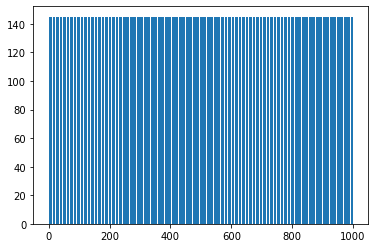

NOTE: The current size of remaining data is 144000
NOTE: The current size of remaining data is 144000
====== Total Num of Half Balanced Test Set is 30000 ========
NOTE: The current size of remaining data is 114000
====== Total Num of Train Set is 114000 ========


In [5]:
# get clustering data
feature_type = 'sup'
intra_type = 'lt'
inter_type = 'bl'

cls_data = torch.load(SUP_DATA)
cls_data, idx2label = cluster_ranking(cls_data)

# generate data
trainset, valset, testset_lt, testset_bl, testset_bbl = generate_train_val_test(cls_data, intra_type=intra_type, inter_type=inter_type)
save_output()

===== Total Number of Images is 1281167 =====
Intra-Distribution is [7, 2, 1]
NOTE: The current size of remaining data is 1281167
====== Total Num of Both Balanced Test Set is 60000 ========
NOTE: The current size of remaining data is 1221167
====== Total Num of Half Balanced Test Set is 60000 ========
NOTE: The current size of remaining data is 1161167


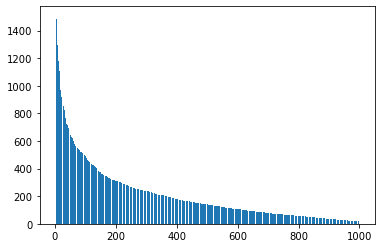

NOTE: The current size of remaining data is 203460
====== Total Num of IID Set is 60000 ========
NOTE: The current size of remaining data is 143460
====== Total Num of IID Set is 30000 ========
NOTE: The current size of remaining data is 113460
====== Total Num of Train Set is 113460 ========


In [6]:
# get clustering data
feature_type = 'sup'
intra_type = 'lt'
inter_type = 'lt'

cls_data = torch.load(SUP_DATA)
cls_data, idx2label = cluster_ranking(cls_data)

# generate data
trainset, valset, testset_lt, testset_bl, testset_bbl = generate_train_val_test(cls_data, intra_type=intra_type, inter_type=inter_type)
save_output()